In [41]:
import numpy as np
from sortedcontainers import SortedSet
from math import sqrt

In [42]:
class MyPriorityQueue(object):
    def __init__(self, current_heuristic, target, probability):
        self.current_heuristic = current_heuristic
        self._data = SortedSet()
        self.target = target
        self.g = dict()
        self.h = dict()
        self.probability = probability
        self.dirx = [0, 0, -1, 1, -1, -1,1,1]
        self.diry = [1, -1, 0, 0, 1, -1,1,-1]
    def __len__(self):
        return len(self._data)
    def push(self, item):
        node = (self.probability[item],self.calculate_priority(item), self.get_heuristic(item), item)
        self._data.add(node)
    def pop(self):
        node = self._data.pop(0)[3]
        return node
    def manhattan_distance(self, x, y): ### Manhattan Distance-> heuristic = |x0-y0| + |x1-y1|, x = [x0,x1] y = [y0,y1]
        return abs(x[0] - y[0]) +abs(x[1] - y[1])
    def euclidean_distance(self, x, y): ### Euclidean Distance-> heuristic = sqrt( (x0-y0)**2 + (x1-y1)**2 ), x = [x0,x1]
                                        ##  y = [y0,y1]
        return sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)
    def chebyshev_distance(self, x, y): ### Chebyshev Distance-> heuristic = max(abs(x0-y0),abs(x1-y1)),
                                        ### x = [x0,x1] y = [y0,y1]
        return max(abs(x[0] - x[1]), abs(y[0] - y[1]))
    def get_heuristic(self, x):
        measure = self.current_heuristic
        if measure == 'm':
            self.h[x] = self.manhattan_distance(x, self.target)
        elif measure == 'e':
            self.h[x] = self.euclidean_distance(x, self.target)
        elif measure == 'c':
            self.h[x] = self.chebyshev_distance(x, self.target)
        return self.h[x]
    def calculate_priority(self, x):            
        return self.g[x] + self.get_heuristic(x) + self.probability[x]

In [43]:
class GridWorld:
    def __init__(self, grid, start, target, n, m):
        '''
        Notations in grid: If grid contains 0, it means the cell is empty
                            and if the grid contains 1, it means the cell is blocked
                            and if the grid contains -1, it means the cell is unconfirmed
        '''
        self.n = n ## Number of columns
        self.m = m ## Number of rows
        self.start = start  ## Starting cell of the agent
        self.target = target ## Target cell of the agent
        self.trajectory = [] ## Trajectory followed by the agent
        self.grid = grid  ## Grid containing complete knowledge
        self.dirx8 = [0, 0, 1, -1, 1, -1, 1, -1] ## Directions used for sensing
        self.diry8 = [1, -1, 0, 0, 1, -1, -1, 1] ## Directions used for sensing
        self.dirx4 = [0, 0, 1, -1]  ## Directions used for traversing
        self.diry4 = [1, -1, 0, 0]  ## Directions used for traversing
        self.sensed_x = set() ## List of cells sensed by agent
        self.status_x = {} ## Denotes the status of the cell. 1-> confirmed block, 0-> confirmed unblocked, 
                            ## -1 -> unconfirmed
        self.cx = {} ## Denotes number of neighbours that are sensed to be blocked (using partial sensing)
        self.bx = {} ## Denotes number of neighbours of x confirmed to be blocked
        self.ex = {} ## Denotes number of neighbours of x confirmed to be empty
        self.hx = {} ## Denotes number of neihbours of x that are unconfirmed
        self.nx = {} # Number of neighbours cell x has
    def pre_computation(self):
        for i in np.arange(self.m):
            for j in np.arange(self.n):
                nx = 0
                for k in np.arange(8):
                    childx = i + self.dirx8[k]
                    childy = j + self.diry8[k]
                    if(childx>=0 and childx<self.m and childy>=0 and childy<self.n):
                        nx+=1
                cell = (i,j)
                self.nx[cell] = nx
                self.hx[cell] = nx
            
    def partial_sensing(self, cell, agentGridObject):
        ''' 
            Returns number of cells that are blocked by accessing true grid
            Calculates number of neighbours of a cell
            Calculates cx
        '''
        x = cell[0]
        y = cell[1]
        cx = 0
        for i in np.arange(8):
            childx = x + self.dirx8[i]
            childy = y + self.diry8[i]
            if(childx >= 0 and childx < self.m and childy>=0 and childy<self.n):
                if(self.grid[childx][childy] == '1'):
                    cx+=1
        agentGridObject.cx[cell] = cx ## Updating partial sensing information for the agent
        agentGridObject.ex[cell] = agentGridObject.ex.get(cell, 0)
        agentGridObject.bx[cell] = agentGridObject.bx.get(cell, 0)
        agentGridObject.sensed_x.add(cell) ## Adding cell to the set of sensed cells
        return cx
    def visit_cell(self, cell, agentGridObject):
        '''
            If the agent goes to the next cell, it will get sense whether the next cell is blocked or not
        '''
        x = cell[0]
        y = cell[1]
        agentGridObject.status_x[cell] = int(self.grid[x][y])
        agentGridObject.grid[x][y] = self.grid[x][y]
        return int(self.grid[x][y])
    def update_neighbours(self, cell, type_):
        currx = cell[0]
        curry = cell[1]
        for i in np.arange(8):
            childx = currx + self.dirx8[i]
            childy = curry + self.diry8[i]
            child = (currx, curry)
            if(childx >= 0 and childx < self.m and childy>=0 and childy<self.n):
                if(type_ == 1):
                    self.bx[child] = self.bx.get(child,0) + 1
                else:
                    self.ex[child] = self.ex.get(child, 0) + 1
                self.hx[child] = self.hx[child] - 1

In [44]:
from collections import deque
class Inference_Agent5:
    def __init__(self, agentGridObject,m,n):
        self.agentGridObject = agentGridObject # Object representing the gridworld of the Agent
        self.dirx8 = [0, 0, 1, -1, 1, -1, 1, -1] # Direction used for sensing
        self.diry8 = [1, -1, 0, 0, 1, -1, -1 ,1] # Direction used for sensing
        self.kb_eqns = [] ## This is list of equation. One equation is represented as a list where first element is a set
                          ## of tuples and the second element is the value.
        self.q = deque()
        self.m = m
        self.n = n
    def mark_cell(self, type_, cell):
        currx = cell[0]
        curry = cell[1]
        cell = (currx, curry)
        if(cell not in self.agentGridObject.status_x or self.agentGridObject.status_x[cell]==-1):
            self.agentGridObject.update_neighbours(cell, type_)
        if(type_ == 1):
            self.agentGridObject.status_x[cell] = 1
            self.agentGridObject.grid[currx][curry] = '1'
        else:
            self.agentGridObject.status_x[cell] = 0
            self.agentGridObject.grid[currx][curry] = '0'
    def put_val_kb(self):
        '''
        This function checks for each eqn in kb_eqns and updates each equation according to the current knowledge of the 
        agent. The new equation is removed from knowledge base and added in the queue.
        '''
        
        idx = 0
        for eqn in self.kb_eqns:
            var = eqn[0] ## This is a set of tuples
            val = eqn[1] ## This is the value in RHS
            flag = False
            new_eqn = set()
            for cell in var:
                if cell in self.agentGridObject.status_x and self.agentGridObject.status_x[cell]!=-1:
                    change= self.agentGridObject.status_x[cell]
                    val = val - change
                    flag= True
                else:
                    new_eqn.add(cell)
            if(flag):
                self.kb_eqns.pop(idx)
                self.q.appendleft([new_eqn,val])
            idx+=1
    def get_eqn_current_cell(self, cell):
        '''
            Generate an equation for a cell, according to the current knowledge of the agent.
        '''
        var = set()
        val = self.agentGridObject.cx[cell]
        currx = cell[0]
        curry = cell[1]
        for i in np.arange(8):
            childx = currx + self.dirx8[i]
            childy = curry + self.diry8[i]
            child = (childx,childy)
            if(childx>=0 and childx<self.m and childy>=0 and childy<self.n):
                if(child not in self.agentGridObject.status_x or self.agentGridObject.status_x[child] == -1):
                    var.add(child)
                else:
                    val = val - self.agentGridObject.status_x[child]
        return var, val
    def check_solvability(self, eqn):
        '''
            Check whether the current equation is solvable of not.
            Two cases:
            if number of variables == val --> then all the value of variables is 1.
            if val == 0 --> then the value of all variables is 0
        '''
        var = eqn[0]
        val = eqn[1]
        flag = False
        if(len(var) == val):
            ### All the variables are equal to 1
            flag = True
            for cell in var:
                currx = cell[0]
                curry = cell[1]
                if(cell not in self.agentGridObject.status_x or self.agentGridObject.status_x[cell]==-1):
                    self.agentGridObject.update_neighbours(cell, 1)
                self.agentGridObject.status_x[cell] = 1
                self.agentGridObject.grid[currx][curry] = '1'
#                 self.agentGridObject.update_neighbours(cell, 1)
        elif(val == 0):
            ### All the variables are equal to 0
            flag = True
            for cell in var:
                currx = cell[0]
                curry = cell[1]
                if(cell not in self.agentGridObject.status_x or self.agentGridObject.status_x[cell]==-1):
                    self.agentGridObject.update_neighbours(cell, 0)
                self.agentGridObject.grid[currx][curry] = '0'
                self.agentGridObject.status_x[cell] = 0
#                 self.agentGridObject.update_neighbours(cell, 0)
        return flag
    def simplify_eqn(self, eqn):
        '''
            Simplifies the equation, according to the current knowledge of the grid.
        '''
        var = eqn[0]
        val = eqn[1]
        new_eqn = set()
        for cell in var:
            if(cell in self.agentGridObject.status_x and self.agentGridObject.status_x[cell]>=0):
                val = val - self.agentGridObject.status_x[cell]
            else:
                new_eqn.add(cell)
        return [new_eqn, val]
    def check_subsequence(self, eqn1, eqn2):
        '''
            Check if eqn2 is subsequence of eqn1
        '''
        var1 = eqn1[0] 
        val1 = eqn1[1]
        var2 = eqn2[0]
        val2 = eqn2[1]
        return var2.issubset(var1)
    def simplify_kb_subsequence(self, q_eqn):
        idx = 0
        flag = True ### Denotes whether the current equation will be added to KB or not
        for kb_eqn in self.kb_eqns:
            if(kb_eqn==q_eqn): 
                flag = False
                break          ############
            res = self.check_subsequence(kb_eqn, q_eqn) ## Will be True if q_eqn is subsequence of kb_eqn
            var_kb = kb_eqn[0]
            val_kb = kb_eqn[1]
            var_q = q_eqn[0]
            val_q = q_eqn[1]
            if(res == True):
                #######  No. 2 ######## Will reduce the eqn of KB
                self.kb_eqns.pop(idx)
                new_eq_kb = var_kb.difference(var_q)
                new_val_kb = val_kb - val_q
                if( len(new_eq_kb) == 1 ):
                    single_var = next(iter(new_eq_kb))
                    if(single_var not in self.agentGridObject or self.agentGridObject.status_x[single_var]==-1):
                        self.agentGridObject.update_neighbours(single_var, new_val_kb)
                    self.agentGridObject.status_x[single_var] = new_val_kb
                    self.agentGridObject.grid[single_var[0]][single_var[1]] = str(new_val_kb)
#                     self.agentGridObject.update_neighbours(single_var, new_val_kb)
                else:
                    self.q.append([new_eq_kb,new_val_kb])
            res = self.check_subsequence(q_eqn, kb_eqn) ## Will be True if kb_eqn is subsequence of q_eqn
            if(res == True):
                flag = False
                ####### No. 1 ######### Will reduce the eqn of queue
                new_q_eqn = var_q.difference(var_kb)
                new_q_val = val_q - val_kb
                self.q.appendleft([new_q_eqn, new_q_val])
            idx += 1
        self.put_val_kb()
        return flag
    def simplify_kb_setDiff(self, eqn):
        var_q = eqn[0]
        val_q = eqn[1]
        flag = True
        for kb_eqn in self.kb_eqns:
            var_kb = kb_eqn[0]
            val_kb = kb_eqn[1]
            ##### We choose first and secnod s.t. first[1]-second[1] = rhs>=0
            first = eqn
            second = kb_eqn
            if(first[1]-second[1]<0):
                temp = first
                first = second
                second = temp
            rhs = first[1] - second[1]
            lhs = first[0].difference(second[0])
            if(len(lhs) == rhs):
                flag = False
                neg_lhs = second[0].difference(first[0])
                for cell in lhs:
                    if(cell not in self.agentGridObject.status_x or self.agentGridObject.status_x[cell]==-1):
                        self.agentGridObject.update_neighbours(cell, 1)
                    self.agentGridObject.status_x[cell] = 1
                    self.agentGridObject.grid[cell[0]][cell[1]] = '1'
#                     self.agentGridObject.update_neighbours(cell, 1)
                for cell in neg_lhs:
                    if(cell not in self.agentGridObject.status_x or self.agentGridObject.status_x[cell]==-1):
                        self.agentGridObject.update_neighbours(cell, 0)
                    self.agentGridObject.status_x[cell] = 0
                    self.agentGridObject.grid[cell[0]][cell[1]] = '0'
#                     self.agentGridObject.update_neighbours(cell, 0)
        self.put_val_kb()
        return flag
            
    def infer(self, type_, cell):
        m = self.agentGridObject.m
        n = self.agentGridObject.n
        '''
        Function starts inferrencing from the node that is present in planned_path. First, we will mark the cell and update
        the value of current cell in knowledge base equations.
        '''
        self.mark_cell(type_, cell) ## This function marks the current cell as blocked or unblocked
        self.put_val_kb()
        var, val = self.get_eqn_current_cell(cell)
        self.q.append([var,val])
        while(len(self.q)>0):
            eqn = self.q.popleft()
            eqn = self.simplify_eqn(eqn)
            flag = self.check_solvability(eqn)
            if(flag):
                self.put_val_kb()
                continue
            add_to_KB1 = self.simplify_kb_subsequence(eqn)
            add_to_KB2 = self.simplify_kb_setDiff(eqn)
            if( add_to_KB1 and add_to_KB2 ):
                self.kb_eqns.append(eqn)

In [45]:
class Agent5:
    def __init__(self, n, m, start, target, inference_agent, grid,agent_grid):
        self.n = n ## Number of columns in grid
        self.m = m ## Number of rows in the grid
        self.start = start ## The start cell of the grid
        self.target = target ## The target cell of the grid
        self.agent_grid = agent_grid  ## The current knowledge of the agent_grid
        self.dirx4 = [-1,1,0,0] ## 4 Directions for the agent to travel
        self.diry4 = [0,0,-1,1] ## 4 Directions for the agent to travel
        self.inference_agent = inference_agent
        self.grid = grid # The full knowledge of the maze
        self.num_bumps = 0 ## Number of bumps in planned_path
        self.sum_num_cells_processed = 0
        self.sum_a_star = 0
        self.probability = {}
        self.score = {}
        self.dirx8 = [0, 0, 1, -1, 1, -1, 1, -1] # Direction used for sensing
        self.diry8 = [1, -1, 0, 0, 1, -1, -1 ,1] # Direction used for sensing
    def a_star(self, source, current_heuristic = 'm'):
        '''
            A-star algorithm that plans path based on current knowledge of the agent
        '''
        dirx = [-1, 1, 0, 0] ## calculates the neighbours of the current node
        diry = [0, 0, 1, -1] ## calculates the neighbours of the current node
        visited = set() ## contains the nodes that have already been added in priority queue
        closed_list = set() ## contains the nodes that have been popped from priority queue
        open_list = MyPriorityQueue(current_heuristic, self.target, self.probability) ## stores the visited nodes and pops it out 
                                                                    ## according to it's priority
        planned_path = [] ## Stores the path that the agent has planned according to it's current knowledge
        open_list.g[source] = 0
        open_list.calculate_priority( source)
        open_list.push( source) ## This function runs in O(logn)
        visited.add(source) #visited[source] = 1
        parent = {} ## stores the parent of each node that is visited
        parent[source] = None
        while(len(open_list)>0):
            curr = open_list.pop()
            self.sum_num_cells_processed+=1
            closed_list.add(curr)
            if(curr[0] == self.target[0] and curr[1] == self.target[1]):
                break
            for i in np.arange(4):
                childx = curr[0] + dirx[i]
                childy = curr[1] + diry[i]
                child = (childx, childy)
                if(childx>=0 and childx<self.m and childy>=0 and childy<self.n and (child not in closed_list) and self.agent_grid.grid[childx][childy]!='1'):
                    if(child not in visited):
                        visited.add(child)
                        parent[child] = curr
                        open_list.g[child] = open_list.g[curr]+1
                        open_list.calculate_priority(child)
                        open_list.push(child) 
                    else:
                        if open_list.g[curr]+1<open_list.g[child]:
                            parent[child] = curr
                            open_list._data.discard(child)
                            open_list.g[child] = open_list.g[curr]+1
                            open_list.calculate_priority(child)
                            open_list.push(child)
        if(self.target not in visited):
            return []
        curr = self.target
        while(curr != source):
            planned_path.append(curr)
            curr = parent[curr]
        planned_path.append(source)
        return planned_path[::-1]
    def check_planned_path(self, planned_path):
        '''
            The agent should call the inference agent after visiting every cell and the inference agent updates the current
            knowledge of the agent. If the agent sees, that a node in the planned_path is blocked, then the agent will 
            start A-star again from the current node.
            
            There will be two types of updates in the current cell->
            Type-0: The current node is set to unblocked, need to update the neighbours accordingly and propagate.
            Type-1: The current node is set to blocked, need to update the neighbours accordingly and propagate.
        '''
        '''
        One mistake in the implementation, if we are not inferring in  the blocked cell, then we are not able to update the 
        neighbours. This is because mark_cell is called in the inference and we are not calling inference in blocked cell.
        '''
        n = len(planned_path)
        traversed_path = []
        restart_cell = None
        for i in np.arange(n):
            cell = planned_path[i]
            currx = cell[0]
            curry = cell[1]
            ## We will start inference only if the next cell is not sensed since if the cell is already sensed then there
            ## will be no update in current knowledge.
            if( cell not in self.agent_grid.sensed_x):
                curr_status = self.grid.visit_cell(cell, self.agent_grid) ## Checking whether curr cell is blocked or not.
#                 if(curr_status!=1):
                self.grid.partial_sensing(cell, self.agent_grid) ## Cell is sensed only if it is not sensed or inferred before
                self.agent_grid.grid[currx][curry] = str(curr_status) ## updating the agent_grid for the current cell.
#                 if(curr_status != 1):
                self.inference_agent.infer(curr_status,cell) ##Start inferring about x
            else:
                curr_status =  self.agent_grid.status_x[cell]
            if(curr_status == 1):
                self.num_bumps += 1
                restart_cell = planned_path[i-1]
                break
            ### the current node is unblocked so if the node in the planned_path is blocked, 
            ### then we need to update the restart node and break from this loop
            ### Will check only the 4 nodes ahead of the current node, since, the inference 
            ### agent will not update beyond 4 nodes
            planned_path_blocked = False
            for j in np.arange(4):
                if(i+j+1 >= n):
                    break
                next_cell = planned_path[i+j+1]
                next_x = next_cell[0]
                next_y = next_cell[1]
                if(self.agent_grid.grid[next_x][next_y] == '1'):
                    planned_path_blocked = True
                    break
            if(planned_path_blocked == True):
                restart_cell = cell
                traversed_path.append(cell)
                break
            traversed_path.append(cell)
        return traversed_path, restart_cell

    def update_probability(self):
#         print("status_x: ",self.agent_grid.status_x)
        for i in np.arange(self.m):
            for j in np.arange(self.n):
                minhx= 8
                curr_prob = 0
                curr = (i,j)
                if( curr in self.agent_grid.status_x and self.agent_grid.status_x[curr]!=-1):
                    self.probability[curr] = self.agent_grid.status_x[curr]
                    continue
                for k in np.arange(8):
                    newx = i + self.dirx8[k]
                    newy = j + self.diry8[k]
                    if(newx>=0 and newx<self.m and newy>=0 and newy<self.n):
                        child = (newx, newy)
                        if(child in self.agent_grid.cx):
                            cx = self.agent_grid.cx[child]
                            bx = self.agent_grid.bx[child]
                            hx = self.agent_grid.hx[child]
                            if(hx == 0):
                                print("child: ",child, " curr: ", (i,j))
                            if(hx < minhx):
                                minhx = hx
                                curr_prob = (cx - bx)/hx
                self.probability[child] = curr_prob
    def compute_path(self):
        '''
            This agent wll compute the score of each cell in the grid being blocked based on probabilities. The 
            probabilities of each cell will update after each a-star call based on the current knowledge of the
            grid.
        '''
        for i in np.arange(self.m):
            for j in np.arange(self.n):
                self.probability[(i,j)] = 0
        self.agent_grid.pre_computation()
        path = []
        curr = self.start
        while(curr != self.target):
            self.sum_a_star+=1
            planned_path = self.a_star(curr)
            self.update_probability()
            if( len(planned_path) == 0 ):
                return []
            traversed_path, restart_node = self.check_planned_path(planned_path)
            n = len(traversed_path)
            path.append(traversed_path)
            if(traversed_path[n-1] == self.target):
                break
            curr = restart_node
        return path

In [46]:
grid = '....XXXX..XX......X....XX.XXX..X....X.....XXXX..X.X..XX...X...XX..XX.....X.X...XXX.X.X.X.X.X...X.X..'
s = ''
cnt =0
for x in grid:
    if(x == '.'):
        s = s + '0'
    else:
        cnt+=1
        s = s + '1'
print(len(s))
print(cnt)

100
39


In [47]:
2998/10201

0.29389275561219486

In [48]:
n = 10
grid = [] ## matrix that contains full knowledge of gridworld
i = 0
while(i<n*n):
    grid.append(list(s[i:i+n]))
    i = i + n
grid = np.array(grid)
print(grid)

[['0' '0' '0' '0' '1' '1' '1' '1' '0' '0']
 ['1' '1' '0' '0' '0' '0' '0' '0' '1' '0']
 ['0' '0' '0' '1' '1' '0' '1' '1' '1' '0']
 ['0' '1' '0' '0' '0' '0' '1' '0' '0' '0']
 ['0' '0' '1' '1' '1' '1' '0' '0' '1' '0']
 ['1' '0' '0' '1' '1' '0' '0' '0' '1' '0']
 ['0' '0' '1' '1' '0' '0' '1' '1' '0' '0']
 ['0' '0' '0' '1' '0' '1' '0' '0' '0' '1']
 ['1' '1' '0' '1' '0' '1' '0' '1' '0' '1']
 ['0' '1' '0' '0' '0' '1' '0' '1' '0' '0']]


In [49]:
grid = np.array([
    ['0','0','1','0','0'],
    ['0','1','1','0','0'],
    ['0','0','0','0','0'],
    ['0','0','0','0','0'],
    ['0','0','0','0','0']
])

In [50]:
n = 5
m = 5
start = (0,0)
target = (m-1,n-1)
gridObject = GridWorld(grid, start, target, n, m) ### Original grid knowledge object
agentGridObject = GridWorld(np.full((m,n),'0'), start, target, n, m) ### Agent Grid Object
inference_agent = Inference_Agent5(agentGridObject,m,n) ### AgentGrid
grid_agent = Agent5(n,m,start,target,inference_agent,gridObject, agentGridObject)
grid_agent.compute_path()
print(grid_agent.num_bumps)

1


In [51]:
import numpy as np
p_values = np.linspace(0,0.33,34)
print(p_values)
result_x = p_values[1:50]

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33]


In [52]:
### Plots --> avg len of trajectory, avg number of cells processed, avg num of bumps

def calculate_path_length(ans_compute_path):
    ans = 0
    for x in ans_compute_path:
        ans = ans + len(x)-1
    return ans + 1
from tqdm import tqdm
cnt = 0
result_y = []
# p_values = np.round(p_values,2)
# result_x = p_values[1:50]
avg_num_cells_processed = []
avg_bumps = []
avg_astar = []
m = 101
n = 101
start = (0,0)
target = (m-1,n-1)
for p in tqdm(p_values):
    if p == 0 or  p== 1:
        continue
    print("Started for p: ",p)
    sum_num_cells_processed = 0
    sum_bumps = 0
    sum_astar = 0
    cnt = 0
    with open('C:/Users/karan/Desktop/Rutgers Courses/CS520/Project2/Grid_data_Proj_2/'+'p'+str(p)+'.txt') as f:
        grid_data = f.readlines()
        freq = 0
        for s in grid_data:
            new_s = ''
            for c in s:
                if(c == '.'):
                    new_s +='0'
                else:
                    new_s += '1'
            i = 0
            grid = [] ## matrix that contains full knowledge of gridworld
            m = 101
            n = 101
            start = (0,0)
            target = (m-1,n-1)
            while(i<m*n):
                grid.append(list(new_s[i:i+n]))
                i = i + n
            grid = np.array(grid)
            gridObject = GridWorld(grid, start, target, n, m) ### Original grid knowledge object
            agentGridObject = GridWorld(np.full((m,n),'0'), start, target, n, m) ### Agent Grid Object
            inference_agent = Inference_Agent5(agentGridObject,m,n) ### Inference Agent Grid
            grid_agent = Agent5(n,m,start,target,inference_agent,gridObject, agentGridObject)
            ans = grid_agent.compute_path()
            sum_num_cells_processed += grid_agent.sum_num_cells_processed
            sum_bumps += grid_agent.num_bumps
            sum_astar += grid_agent.sum_a_star
            cnt+=1
            if(cnt == 250):
                break
        avg_num_cells_processed.append(sum_num_cells_processed/250)
        avg_bumps.append(sum_bumps/250)
        avg_astar.append(sum_astar/250)
        print(sum_bumps)
        print(sum_bumps/250)
        

  0%|                                                                                           | 0/34 [00:00<?, ?it/s]

Started for p:  0.01


  3%|██▍                                                                                | 1/34 [00:00<00:12,  2.68it/s]

child:  (1, 71)  curr:  (0, 70)


ZeroDivisionError: division by zero

In [15]:
import pickle
with open('agent_2_avg_bumps.pkl', 'rb') as f:
    agent_2_avg_bumps = pickle.load(f)
with open('agent_1_avg_bumps.pkl', 'rb') as f:
    agent_1_avg_bumps = pickle.load(f)
with open('agent_3_avg_bumps.pkl', 'rb') as f:
    agent_3_avg_bumps = pickle.load(f)
with open('Agent-4-inference-done-on-negative.pkl', 'rb') as f:
    agent_4_avg_bumps = pickle.load(f)

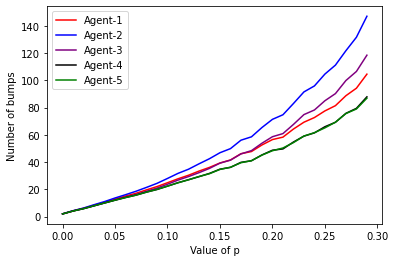

In [16]:
import matplotlib.pyplot as plt
plt.plot(p_values[:-1], agent_1_avg_bumps,color = "red", label="Agent-1")
plt.plot(p_values[:-1], agent_2_avg_bumps,color = "blue", label="Agent-2")
plt.plot(p_values[:-1], agent_3_avg_bumps,color = "purple", label="Agent-3")
plt.plot(p_values[:-1], agent_4_avg_bumps,color = "black", label="Agent-4")
plt.plot(p_values[:-1], avg_bumps,color = "green", label="Agent-5")
plt.xlabel('Value of p')
plt.ylabel('Number of bumps')
plt.legend()

In [69]:
np.array(avg_bumps) - np.array(agent_4_avg_bumps)

array([ 0.004,  0.   ,  0.004,  0.068, -0.008,  0.04 , -0.076,  0.012,
        0.072,  0.1  ,  0.012,  0.028,  0.08 ,  0.096,  0.024, -0.164,
        0.188, -0.208,  0.1  , -0.048, -0.412,  0.824, -0.64 , -0.072,
       -0.14 , -0.708, -0.164, -0.224, -0.616, -0.96 ])

In [19]:
# import pickle
# with open('Agent-5-based-on-score.pkl', 'wb') as f:
#        pickle.dump(avg_bumps, f)